In [1]:
import numpy as np
import torch

def exposureRGB(img, R_a, R_b, G_a, G_b, B_a, B_b):
    #rgb_img = img.copy()
    rgb_img = img.clone()
    rgb_img[:, :, 0] = (rgb_img[:, :, 0]*R_a) + R_b
    rgb_img[:, :, 1] = (rgb_img[:, :, 1]*G_a) + G_b
    rgb_img[:, :, 2] = (rgb_img[:, :, 2]*B_a) + B_b
    
    #rgb_img = np.clip(rgb_img, 0, 1)
    rgb_img = torch.clamp(rgb_img, 0, 1)
    
    return rgb_img

def exposureRGB_Tens(inp, out_g):
    # Splitting the output tensor into individual parameter tensors
    R_a = out_g[:, 0, :, :]
    R_b = out_g[:, 1, :, :]
    G_a = out_g[:, 2, :, :]
    G_b = out_g[:, 3, :, :]
    B_a = out_g[:, 4, :, :]
    B_b = out_g[:, 5, :, :]

    # Applying the exposure transformation to the input image
    rgb_img = inp.clone()
    rgb_img[:, 0, :, :] = (inp[:, 0, :, :] * R_a) + R_b
    rgb_img[:, 1, :, :] = (inp[:, 1, :, :] * G_a) + G_b
    rgb_img[:, 2, :, :] = (inp[:, 2, :, :] * B_a) + B_b
    
    # Clipping the values to maintain the range [0, 1]
    rgb_img = torch.clamp(rgb_img, 0, 1)
    
    return rgb_img

In [2]:
class PSNR():
    def __init__(self):
        pass

    def adjust_dimensions(self, x):
        if x.dim() == 3:
            x = x.unsqueeze(0)
        return x

    def __call__(self, ref, res):
        ref = self.adjust_dimensions(ref)
        res = self.adjust_dimensions(res)
        
        mse = torch.mean((ref - res) ** 2, dim=(1, 2, 3)) # mse for each element in the batch (b, c, h, w)
        psnr = 10 * torch.log10(1 / mse) # psnr for each mse in the batch

        return torch.mean(psnr)


In [3]:
import cv2
import numpy as np
def read_image(image_path, grayscale=False):
    img = cv2.imread(image_path, cv2.IMREAD_UNCHANGED)

    if not grayscale:
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = img.astype(np.float32) / 255.0
    return img

In [4]:
from torch.autograd import Variable
Tensor = torch.cuda.FloatTensor if 0 >= 0 else torch.FloatTensor

MSE Loss between Original and Transformed Image: 0.010080724954605103
MSE Loss between Transformed Image and Ground Truth: 0.010869323275983334


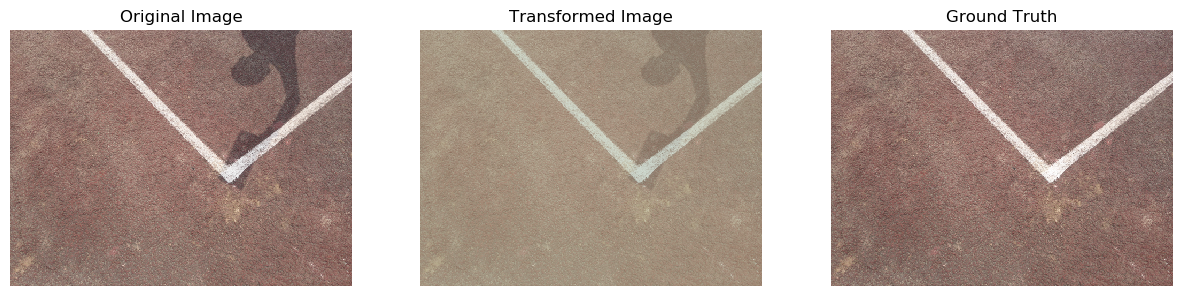

In [27]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt

# Example paths (adjust as necessary)
path = '/home/vhaardt/Desktop/ShadowRemoval/data/ISTD_Dataset/train/train_A/1-1.png'
path_gt = '/home/vhaardt/Desktop/ShadowRemoval/data/ISTD_Dataset/train/train_C/1-1.png'

# Read the original image and ground truth
img_original = read_image(path)
gt_original = read_image(path_gt)

# Convert numpy arrays to PyTorch tensors and ensure they're of type float
img_tensor = torch.from_numpy(img_original).float()
gt_tensor = torch.from_numpy(gt_original).float()

# Ensure img_tensor and gt_tensor have shape (C, H, W)
if img_tensor.ndimension() == 3 and img_tensor.shape[2] == 3:  # (H, W, C)
    img_tensor = img_tensor.permute(2, 0, 1)  # Convert to (C, H, W)

if gt_tensor.ndimension() == 3 and gt_tensor.shape[2] == 3:  # (H, W, C)
    gt_tensor = gt_tensor.permute(2, 0, 1)  # Convert to (C, H, W)

# Now you can use tensors directly (Variables are deprecated)
img_variable = img_tensor

# Transform the original image (assuming exposureRGB returns a float32 image)
#img_transformed = exposureRGB(img_variable, 3, 10, 1, 0, 1, 0)0.4436, 0.3879, 0.5527, 0.3215, 0.5874, 0.2487
img_transformed = img_variable.clone()
img_transformed[0, :, :] = (img_transformed[0, :, :]*0.4436) + 0.3879
img_transformed[1, :, :] = (img_transformed[1, :, :]*0.5527) + 0.3215
img_transformed[2, :, :] = (img_transformed[2, :, :]*0.5874) + 0.2487
img_transformed = torch.clamp(img_transformed, 0, 1)

# Define the MSE loss function
loss_fn = nn.MSELoss()
PSNR_ = PSNR()

# Compute the MSE loss between the original and transformed images
loss_original_transformed = loss_fn(img_variable, img_transformed)

# Compute the MSE loss between the transformed image and the ground truth
loss_transformed_gt = loss_fn(img_transformed, gt_tensor)

# Print the losses
print(f'MSE Loss between Original and Transformed Image: {loss_original_transformed.item()}')
print(f'MSE Loss between Transformed Image and Ground Truth: {loss_transformed_gt.item()}')

# For visualization, convert tensors back to numpy arrays
img_original = img_variable.cpu().numpy().transpose(1, 2, 0)  # (C, H, W) -> (H, W, C)
img_transformed_visual = img_transformed.cpu().numpy().transpose(1, 2, 0)  # (C, H, W) -> (H, W, C)
gt_visual = gt_tensor.cpu().numpy().transpose(1, 2, 0)  # (C, H, W) -> (H, W, C)

# Plot the images using matplotlib
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
axes[0].imshow(img_original)
axes[0].set_title('Original Image')
axes[0].axis('off')

axes[1].imshow(img_transformed_visual)
axes[1].set_title('Transformed Image')
axes[1].axis('off')

axes[2].imshow(gt_visual)
axes[2].set_title('Ground Truth')
axes[2].axis('off')

plt.show()

In [21]:
img_transformed[:, :, :].shape

torch.Size([3, 480, 640])